Dataset: https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network#

paper: https://gi.copernicus.org/articles/4/121/2015/gi-4-121-2015.pdf 

# Table of content

[1. Introduction](#intro)<br>

[2. Models gradients and losses](#models)<br>

[2.1  Linear regression](#models_regression)<br>
[2.2  Check for Linear regression](#models_regression_check)<br>
[2.3  Logistic regression](#models_logistic)<br>
[2.4  Check for logistic regression](#models_logistic_check)<br>


[3. Solvers](#solvers)<br>

[3.1 Tools for solvers](#tools)<br>
[3.2 Gradient descent](#gd)<br>
[3.3 Stochastic Gradient descent](#sgd)<br>
[3.4 Stochastic Average Gradient descent](#sag)<br>
[3.5 Stochastic Variance Reduced Gradient descent](#svrg)<br>
[3.6 Adam](#adam)<br>

[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

In [ ]:
!pip install wget

from numpy.random import multivariate_normal
from scipy.linalg import toeplitz
from numpy.random import randn

import requests
import csv
import wget   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00328/ghg_data.zip'
file_name = 'datasetGHG'
wget.download(url, file_name)
!unzip /content/datasetGHG

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=d8e5bad083aa834a1bd7e53b782e9109068c0b8c19ed54a268503a9b62d16a01
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


'datasetGHG'

In [ ]:
# read .dat to feature and label vectors
'''    
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
'''
N = 2921 # number of data 
d = int(5232/16*15) # number of features
count = ["%04d" % x for x in range(1, N+1)]
X = np.zeros((N, d))
avg = np.zeros(N)
for n in range(1, N+1):
    datContent = [i.strip().split() for i in open("./ghg_data/ghg.gid.site{}.dat".format(count[n-1])).readlines()]
    X[n-1,:] = np.array(datContent[:15]).astype(float).reshape((-1))
    avg[n-1] = np.average(np.array(datContent[15]).astype(float))
avgAll = np.average(avg)
y = [-1 if avg[i]<avgAll else 1 for i in range(N)]
y = np.array(y)
# print(X.shape)
# print(y.shape)

(2921, 4905)
(2921,)


## 1.2. Simulation of a linear model

In [ ]:
def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

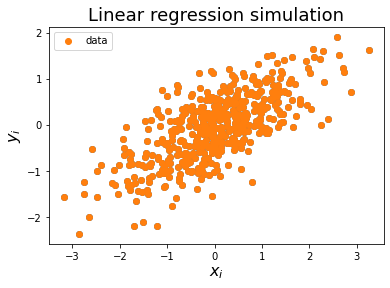

In [ ]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()
# send(plt, 1)

## 1.3. Simulation of a logistic regression model

In [ ]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

In [ ]:
u = np.array([1,2,3])
sigmoid(u)

array([0.73, 0.88, 0.95])

Text(0.5, 1.0, 'Logistic regression simulation')

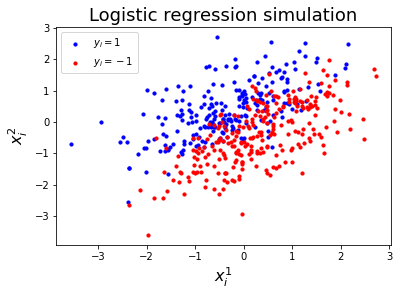

In [ ]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)
# send(plt, 2)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

<a id='models_regression'></a>



## 2.1 Linear regression

In [ ]:
from numpy.linalg import norm

class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradients of  f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradients of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()
    
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        return(X.T.dot(X))/ n_samples + self.strength

<a id='models_regression_check'></a>

## 2.2 Checks for the linear regression model

<ipython-input-12-2a5f72b69823>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(w0)


Text(0.5, 1.0, 'Model weights')

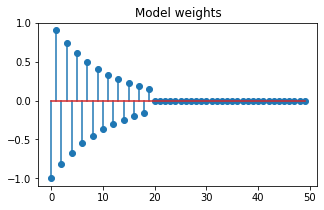

In [ ]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

In [ ]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

# send(float(check_grad(model.loss, model.grad, w)), 3)
print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

3.567738022588874e-06


In [ ]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 4.157074308347419
lip_max= 115.25447959194987
lip_coordinates= [1.08 1.02 1.07 1.09 1.01 1.   1.02 0.99 1.09 0.98 0.97 1.   0.99 1.02
 0.96 0.92 0.97 1.09 0.97 0.96 0.98 1.11 1.   1.07 0.98 0.9  1.07 1.09
 1.02 1.02 0.92 0.97 0.93 1.09 0.91 0.92 1.02 0.96 0.94 1.01 0.97 0.98
 0.96 0.98 0.96 1.   1.03 1.01 0.99 0.95]


In [ ]:
model.hessian().shape

(50, 50)

<a id='models_logistic'></a>

## 2.3 Logistic regression

**1) Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).**

**2) Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below.**

In [ ]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * np.linalg.norm(w) ** 2
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X.T.dot(u))/n_samples + strength * w
    
    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        strength = self.strength
        u = y[i]*np.exp(- y[i] * (x_i.dot(w)))/(1 + np.exp(- y[i] * (x_i.dot(w))))
        return (- u*x_i + strength * w)
    
    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X[:, j].T.dot(u))/n_samples + strength * w[j]


    def lip(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of  f"""
        X, n_samples = self.X, self.n_samples

        return np.linalg.norm(X.T.dot(X), 2) / (4*n_samples) + self.strength


    def lip_coordinates(self):
        """Computes (an upper bound on) the Lipschitz constant of the gradient of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples

        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength


    def lip_max(self):
        """Computes (an upper bound on) the maximum of the lipschitz constants of the gradients of  f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()

     
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()


<a id='models_logistic_check'></a>


## 2.4 Checks for the logistic regression model

**3) Use the function `simu_logreg` to simulate data according to the logistic regression model. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as we did for linear regression above.**

In [ ]:
## Simulation setting
# d = 50
# nnz = 20
# idx = np.arange(n_features)
# w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
# w0[nnz:] = 0.

# plt.figure(figsize=(5, 3))
# plt.stem(w0)
# plt.title("Model weights")

# from scipy.optimize import check_grad

# X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)
w = np.random.randn(d)
print('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w))) # This must be a number (of order 1e-6)


<ipython-input-84-e161bb460475>:29: RuntimeWarning: overflow encountered in exp
  u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
<ipython-input-84-e161bb460475>:29: RuntimeWarning: invalid value encountered in true_divide
  u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
<ipython-input-84-e161bb460475>:24: RuntimeWarning: overflow encountered in exp
  return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * np.linalg.norm(w) ** 2
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Checkgrad returns nan


In [ ]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 427847.1213005799
lip_max= 64015530.27964126
lip_coordinates= [5.60e-03 5.97e-03 9.70e-03 ... 7.64e+00 7.19e+00 6.48e+00]


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression. We want now to code and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

The following tools store the loss after each epoch

In [ ]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg) 
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [ ]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.6e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent


**4) Finish the function `gd` below that implements the gradient descent algorithm and test it using the next cell.**

In [ ]:
def gd(model, w0, step,  n_iter, callback, verbose=True):
    """Gradient descent
    """
    #step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        w_new[:] = w - step * model.grad(w)
        w[:] = w_new # Remark : does operation inplace
        callback(w)
    return w

### The following code runs GD and stores the objectivre values

In [ ]:
callback_gd = inspector(model, n_iter=n_iter)
# step= 1/model.lip()
step = 1e-5
w_gd = gd(model, w0, step=step, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.527010e-01
      20 | 4.888087e-01
      30 | 4.419797e-01
      40 | 4.057349e-01
      50 | 3.766695e-01


- Which step size was chosen?
- What is the expected rate of convergence?

<a id='sgd'></a>
## 3.3. Stochastic gradient descent

**7) Finish the function `sgd` below that implements the st stochastic gradient descent algorithm and test it using the next cell.**

In [ ]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    mu = model.strength
    w = w0.copy()
    w_ave = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        w -= step * model.grad_i(
            i, w) / (np.sqrt(idx + 1))  # decays at 1/sqrt{k} good choice for convex functions
        # decent choice for strongly convex
        # also possible to use (max(mu*(idx + 1), model.lip())) (choice in the slides)
        #w_ave =  idx/(idx+1)*w_ave + 1/(idx+1)*w
        if idx % n_samples == 0:
            callback(w)  #w_ave
    return w

In [ ]:
step = 1e-5
# step = 1 / model.lip_max()
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.931472e-01
      10 | 1.657932e-01
      20 | 1.376708e-01
      30 | 1.242160e-01
      40 | 1.159401e-01
      50 | 1.095295e-01


**Which of the method is  the fastest during the  first 5 passes over the data?**

<a id='sag'></a>
## 3.4. Stochastic average gradient descent


**8) Finish the function `sag` below that implements the stochastic averaged gradient algorithm and test it using the next cell.**

In [ ]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features)) # one gradient per sample n= 60k,  d= 50M  => 3 10^12
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        y_new = model.grad_i(i, w)
        y += (y_new - gradient_memory[i]) / n_samples
        gradient_memory[i] = y_new
        w -= step * y
        if idx % n_samples == 0:
            callback(w)
    return w

In [ ]:
# step = 1 / model.lip_max()
step = 1e-5
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.931472e-01
      10 | 4.030272e-02
      20 | 1.543551e-02
      30 | 8.312852e-03
      40 | 1.007182e-02
      50 | 4.224611e-03


- What happens during the first pass of SAG?
- What is the main problem  of SAG?
- What is  the size of the gradient_memory matrix?

<a id='svrg'></a>
## 3.5. Stochastic variance reduced gradient

**9) Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm and test it using the next cell.**

In [ ]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    temp_sum = 0
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        if idx % n_samples == 0:
            w_old[:] = temp_sum/n_samples
            mu = model.grad(w)
            temp_sum = 0
        i = idx_samples[idx]
        z_new = model.grad_i(i, w)
        z_old = model.grad_i(i, w_old)  ### w_old is the only thinng I keep, I can recompute the gradient f_i (w_old)
        ## SVRG trades memory for computation
        w -= step * (z_new - z_old + mu)
        temp_sum += w
        if idx % n_samples == 0:
            callback(w)
    return w

In [ ]:
# step = 1 / model.lip_max()
step = 1e-5
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.931472e-01
      10 | 1.038645e-01
      20 | 3.047926e-02
      30 | 1.435955e-02
      40 | 7.431445e-03
      50 | 1.224718e-02


<a id='adam'></a>


## 3.6 Adam

**13) Create the function `adam` that implements the adam algorithm and test it.**

In [ ]:
def adam(model, w0, n_iter, step, beta1, beta2, epsilon, callback, verbose=True):
##################
### TODO BLOCK
    "Adam"
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    accumulated_square_gradient = np.zeros(n_features)
    if verbose:
        print("Lauching Adam solver...")
    callback(w)
    for k in range(n_iter + 1):
        gradient = model.grad(w)
        accumulated_gradient = beta1*accumulated_gradient + (1-beta1)*gradient
        accumulated_gradient_correction = accumulated_gradient/(1 - beta1**(k+1))
        accumulated_square_gradient = beta2*accumulated_square_gradient + (1-beta2) *(gradient)**2
        accumulated_square_gradient_correction = accumulated_square_gradient/(1 - beta2**(k+1))
        w -=  (step /(np.sqrt(accumulated_square_gradient_correction) + epsilon))*accumulated_gradient_correction
        callback(w)
    return w

### END TODO BLOCK
##################
# send(adam, 18)

- What is the set of parameters for Adam? 
- What are default choices for those parameters?
- Is Adam typically implemented with deterministic or Stochastic Gradients?

In [ ]:
##################
### TODO BLOCK

step = 0.1
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-6)

callback_adam = inspector(model, n_iter=n_iter)
w_adam = adam(model, w0, n_iter=n_iter, step = step, beta1 = beta1, beta2 = beta2, 
              epsilon = epsilon, callback=callback_adam)
              
### END TODO BLOCK
##################

Lauching Adam solver...
   it    |   obj   
       0 | 6.931472e-01
      10 | 5.513845e-01
      20 | 5.468339e-01
      30 | 5.425152e-01
      40 | 5.372487e-01
      50 | 5.366899e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

**15) Plot the values of the loss for the different iteration and for each solver. Comment. **

In [ ]:
# Modify here to only call the methods you have implemented
callbacks = [callback_gd, callback_sgd, callback_sag, callback_svrg]
names = ["GD", "SGD", "SAG", "SVRG"]

### Let's look at the convergence curves

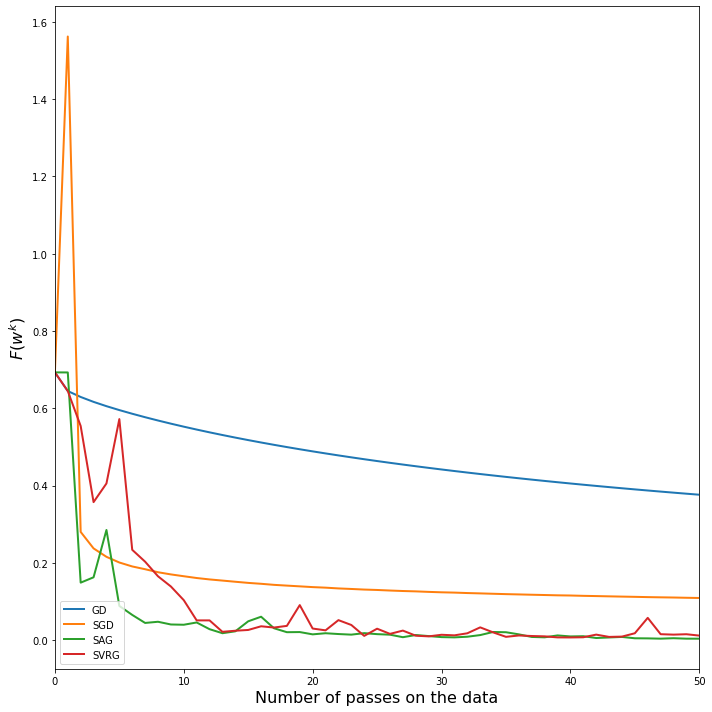

In [ ]:
plt.figure(figsize=(10, 10))

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives 
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) $", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

In [ ]:
# 1 . Compute the minimal value of the function by running CGD (or another fast method)
# for 20 times more iterations than any other method
# 2. Set yscale to log

callback_long = inspector(model, n_iter=1000, verbose=False)
w_gd = gd(model, w0, step=step, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

<ipython-input-126-3ab972ea5263>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((-1, 2e0))


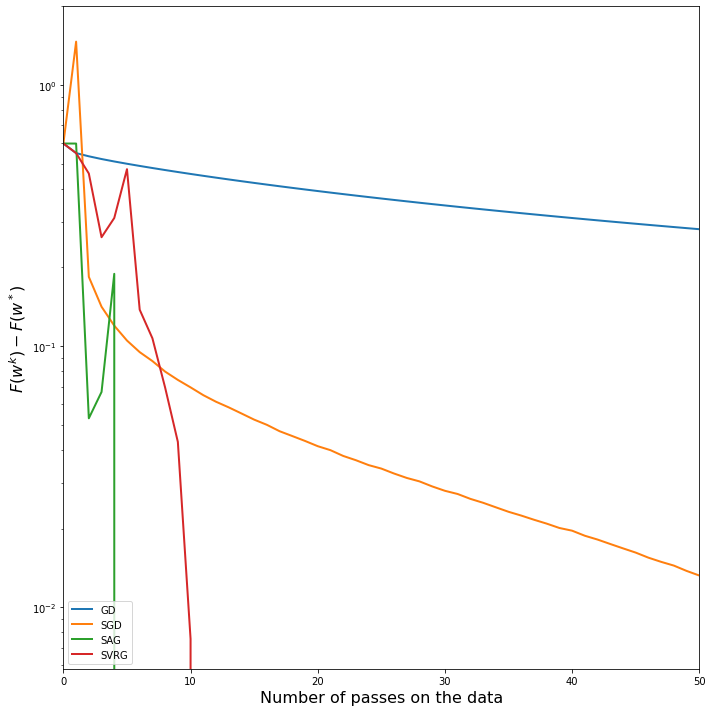

In [ ]:
plt.figure(figsize=(10, 10))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
# plt.ylim((-1, 2e0))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()